# Homework 4: Recurrent Neural Network

<div class="alert alert-block alert-warning">Each assignment needs to be completed independently. Never ever copy others' work (even with minor modification, e.g. changing variable names). Anti-Plagiarism software will be used to check all submissions. </div>

## Objectives:

- Use recurrent neural networks for text classification
- Use recurrent neural networks for timer series regression

In [2]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, Subset, Dataset
import torchvision.transforms as transforms

import torchvision

from numpy.random import seed
import torch
import numpy as np

from torchinfo import summary
import matplotlib.pyplot as plt

In [4]:
# Fix random number so that your traing process can be replicated

random_seed = 124
seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

## Q1: Recurrent Neural Network for Text Classification

Continuing the emotion detection task in HW3, now let's use recurrent nueral network to detect emotion from text. The dataset is taken from https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text.

This task is similar to Task 3 in HW 3. The only difference is that we will use RNN layers (LSTM or GRU)

The following scripts show you how to load the data and split the samples into training, evaluation, and test.

Reuse all the code you use for preprocessing, loading pretrained word vectors, training models, and plotting results. Feel free to use the  reference code I gave.

### Load Data

In [8]:
import pandas as pd
from sklearn.utils import shuffle


In [10]:
data = pd.read_csv("sample_data/Emotion_final.csv")
data.head()
len(data)

data = shuffle(data)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


21459

In [11]:
# Map text label to numbers

label_map = {'fear':0, 'happy':1, 'anger':2, 'surprise':3, 'sadness':4, 'love':5}
data["label"] = data.Emotion.apply(lambda x: label_map[x])
data.head()
data.label.value_counts()

,Text,Emotion,label
11319,i feel impatient with the christian church dis...,anger,2
793,i feel like him try to stay as faithful as pos...,happy,1
11516,im feeling pretty proud most of the elements i...,happy,1
18681,i went to bed feeling pretty proud of myself e...,happy,1
2273,i feel heartbroken mostly for my daughter and ...,sadness,4


1    7029
4    6265
2    2993
0    2652
5    1641
3     879
Name: label, dtype: int64

In [12]:
# Split dataset into training, evaluation, and test

train_data = data.iloc[0: 15000]
eval_data = data.iloc[15000: 18000]
test_data = data.iloc[18000: ]

### Preprocess Text 

[]

15959


1     8380
2     2290
3     1094
4      712
5      463
6      314
7      260
8      195
9      159
10     127
dtype: int64

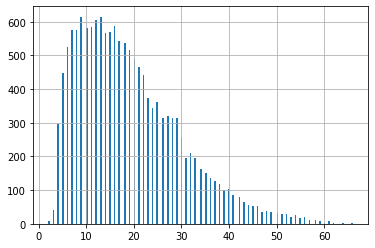

In [13]:
# A few exploration steps. This plots shows the sentence length can be set to 50 
# and vocab size can be set around 8000 
from tensorflow import keras

# check document length
(train_data.apply(lambda row: len(row["Text"].split()), axis = 1)).hist(bins = 200).plot()
#(train_data.apply(lambda row: len(row["title"].split()), axis = 1)).hist(bins = 200).plot()

# check word frequencies
tokenizer = keras.preprocessing.text.Tokenizer()
#tokenizer.fit_on_texts(train_data["title"] +" "+ train_data["text"])
tokenizer.fit_on_texts(train_data["Text"])

print(len(tokenizer.word_counts))
word_counts = pd.Series(list(tokenizer.word_counts.values()))
word_counts.value_counts().sort_values(ascending = False)[0:10]

In [14]:
class News_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x).long()
        self.y = torch.Tensor(y).long()
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.size()[0]


In [15]:
def preprocess(train_data, eval_data, test_data, vocab_size = 10000, max_sent = 50):
    
    tokenizer = keras.preprocessing.text.Tokenizer(num_words = vocab_size)
    tokenizer.fit_on_texts(train_data["Text"])

    train_seq = tokenizer.texts_to_sequences(train_data["Text"])
    train_seq = keras.preprocessing.sequence.pad_sequences(train_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    eval_seq = tokenizer.texts_to_sequences(eval_data["Text"])
    eval_seq = keras.preprocessing.sequence.pad_sequences(eval_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    
    test_seq = tokenizer.texts_to_sequences(test_data["Text"])
    test_seq = keras.preprocessing.sequence.pad_sequences(test_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    # dataset
    train_dataset = News_dataset(train_seq, train_data["label"].values)
    eval_dataset = News_dataset(eval_seq, eval_data["label"].values)
    test_dataset = News_dataset(test_seq, test_data["label"].values)
    
    return train_dataset, eval_dataset, test_dataset, tokenizer

In [16]:
vocab_size = 10000
max_sent = 50

train_dataset, eval_dataset, test_dataset, tokenizer = preprocess(train_data, eval_data, test_data, \
                                                       vocab_size, max_sent )

In [ ]:
#tokenizer.word_index

### Load pretrained word vectors 

In [18]:
pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import torchtext
emb_dim = 100

vector = torchtext.vocab.GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:17<00:00, 22597.74it/s]


In [20]:

missing_words = []  # check if any word without a vector

# initialize embedding matrix
emb_weight = np.zeros((vocab_size, emb_dim))

# loop through all words
for word, idx in tokenizer.word_index.items():

  # align with word index in sentences, since the first 3 indexes are reserved
  if idx < vocab_size :  
    try:
      emb = vector[word]
      emb_weight[idx] = emb    

    # not every word has a vector
    except:
      missing_words.append(word)
    
print(missing_words)

[]


In [21]:
# Check alignment. These two must be the same

idx = tokenizer.word_index['city']
print(emb_weight[idx])

print(vector['city'])

[ 2.65720010e-01  3.48570012e-02  4.90550011e-01 -6.74019992e-01
  3.28830004e-01  9.99170005e-01 -1.03050005e+00  6.94920003e-01
  3.43580008e-01  8.57919991e-01 -4.38039988e-01 -8.18350017e-01
  2.68680006e-01 -2.50829995e-01  1.54660001e-01 -8.32239985e-01
  1.17270005e+00 -1.86039999e-01 -5.29290020e-01  1.76530004e-01
  8.07470024e-01 -1.40310004e-01 -2.40310002e-02 -6.11579977e-03
 -6.02169991e-01 -6.71710014e-01  2.06980005e-01 -5.09480000e-01
 -3.29899997e-01 -3.94540012e-01 -4.59270000e-01 -2.89310008e-01
  7.88110018e-01  4.44830000e-01 -4.86970007e-01 -2.36300007e-01
 -1.50809996e-02  1.66060001e-01 -3.41719985e-02  8.40490013e-02
 -8.60819966e-02 -9.01499987e-01 -2.01989993e-01 -5.60479999e-01
  8.64350021e-01  3.27419996e-01  3.81839991e-01 -2.43340001e-01
  5.97230017e-01  1.74640000e-01 -4.47560012e-01 -3.34769994e-01
  3.24229985e-01  1.02310002e+00 -5.49459994e-01 -2.85200000e+00
 -5.76399982e-01 -3.57600003e-01  1.41040003e+00  3.07570010e-01
 -3.88520002e-01  7.43019

In [22]:
emb_matrix = torch.Tensor(emb_weight)
print(emb_matrix.shape)

torch.Size([10000, 100])


### Q1.1. RNN Model 

Define a recurrent neural netowrk model for this classification task. You model should contain the following:
- `An embedding layer` that is initialized with pre-trained word vectors and can fine-tune the word vectors (as we noticed from HW 3, this configuration worked the best)
- One or more `RNN layers (LSTM or GRU)`


Your model should allow to configure these hyperparameters:
- Embedding layer:
    - Vocabulary size
    - Embedding dimension
    - Pretrained word vectors
- RNN layers:
    - Number of RNN layers
    - Hidden units
    - Bidirectional or not
    
    
Train this model as you did in HW3. You are expected to receive `an accuracy around 89% on the test dataset`.

Analyze your model and answer the following questions:
- How many parameters does your RNN model have? Does this model have more or less parameters than your CNN model in HW3?
- What outputs of the RNN layers (i.e., output of each step, working memory, or cell memory) enter the linear layer to make the label predictions? 
- What hyperparameters of the RNN layers do you think are critical in achieving good performance?

#### Model Definition

In [23]:
class rnn_text(nn.Module):

    # define all the layers used in model
    def __init__(self, vocab_size, emb_dim, num_classes, hidden_units , \
                 num_layers = 1,  bidirectional = False, \
                 emb_weight = None, freeze = False, dropout_rate = 0.5):
      
        super(rnn_text, self).__init__()
        
        self.emb_dim = emb_dim
        
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.bidirectional = bidirectional
        self.num_classes = num_classes
       
        if emb_weight is None:      
            self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = 0)
        else:
            self.embedding = nn.Embedding.from_pretrained(emb_weight, freeze=freeze)
        
        self.rnn = nn.LSTM(input_size = self.emb_dim, hidden_size = self.hidden_units,\
                           num_layers = self.num_layers, \
                           bidirectional = self.bidirectional,\
                           batch_first = True,\
                           #dropout = dropout_rate
                          )
        
        feature_size = self.hidden_units * 2
        if self.bidirectional:
            feature_size = self.hidden_units * 4
            
        self.fc = nn.Linear(feature_size, self.num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x = self.embedding(x) # Batch x sent_len x emb_dim
        #print(x.size())
        #x = torch.swapaxes(x, 1, 2) # Batch x emb_dim x max_sent 

        x, _ = self.rnn(x)  # batch, seq_len, self.hidden_units*(2 if self.bidirectional else 0)
        #print(x.size())
        x = self.dropout(x)
        x = torch.cat([x[:,-1,:],x[:,0,:]], dim = -1)
        
        logit = self.fc(x)  

        return logit

In [24]:
from torchsummary import summary
model = rnn_text(10000, 100, 6, 100 , \
                 num_layers = 1,  bidirectional = True, \
                 emb_weight = None, freeze = False, dropout_rate = 0.5)
                 
                
#summary(model, (16,50))
print(model)

rnn_text(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


#### Training function

In [25]:
from sklearn.metrics import classification_report

def train_model(model, train_dataset, eval_dataset,  device, 
                optimizer, epochs=30, batch_size=64):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    #test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': [],
               'test_acc': 0}
    
    patience = 10
    max_acc = -np.Inf
    cnt = 0
    
    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            
            # move data to device
            x = x.to(device)
            y = y.to(device)
            
            # forward
            outputs = model(x)  # (num_batch, 45) 
            _, pred = torch.max(outputs, dim = -1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item()
            
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in eval_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                
                outputs = model(x)  # (num_batch, 45) 
                _, pred = torch.max(outputs, dim = -1)
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item() 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(eval_loader)).item()
        val_acc = test_acc/len(eval_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f},\
        train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")
        
        if test_acc > max_acc:
            max_acc = test_acc
            cnt = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("model saved!")
        else:
            cnt += 1
            
            if cnt == patience:
                print("early stopping!")
                break
    
    # restore best model
    model.load_state_dict(torch.load("best_model.pth"))
    
    return model, history

In [26]:
def test_model(model, test_dataset, batch_size = 64):    # get test performance
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    test_acc = 0
    ys = []
    preds = []
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)
            y = y.to(device)
            # predict
            outputs = model(x)
            _, pred = torch.max(outputs, dim = -1)
            
            ys.append(y.cpu().numpy())
            preds.append(pred.cpu().numpy())
    
    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    
    test_acc = (preds == ys).astype(int).mean()
    print(classification_report(ys, preds))
        
    print(f"Test acc: {test_acc:.4f}")
    
    return test_acc

In [27]:
def get_plot(hist_list, labels, epochs):
    
    colors = ['red',"blue","green","orange"]
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    for i, hist in enumerate(hist_list):
        ax[0].plot(range(len(hist['val_loss'])), hist['val_loss'], '-', color = colors[i], label=labels[i])
        
    ax[0].set_title('Evaluation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    for i, hist in enumerate(hist_list):
        ax[1].plot(range(len(hist['val_acc'])), hist['val_acc'], '-', color = colors[i], label=labels[i])
        

    ax[1].set_title('Evaluation Acc.')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Acc.')
    ax[1].legend()
   
    plt.show()

#### Train model

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
emb_dim = 100
hidden_units = emb_dim
num_layers = 1
bidirectional = True
num_classes = 6
vocab_size = 10000

In [30]:
# Case C: Use word vectors and allow fine tuning

model_rnn = rnn_text(vocab_size = vocab_size , emb_dim = emb_dim, 
                       num_classes = num_classes, hidden_units = hidden_units , \
                       num_layers = num_layers,  bidirectional =  True, \
                       emb_weight =  emb_matrix, freeze = False, dropout_rate = 0.5)
                  
print(model_rnn)

optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.0005)

model_rnn, hist_rnn = train_model(model_rnn, train_dataset, eval_dataset, \
                           device, optimizer, epochs=100)



rnn_text(
  (embedding): Embedding(10000, 100)
  (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Training Start
Epoch:1 / 100, train loss:1.5344,        train_acc:0.3935, valid loss:1.3523 valid acc:0.5096
model saved!
Epoch:2 / 100, train loss:1.1814,        train_acc:0.5582, valid loss:1.0313 valid acc:0.6131
model saved!
Epoch:3 / 100, train loss:0.8483,        train_acc:0.6897, valid loss:0.7136 valid acc:0.7540
model saved!
Epoch:4 / 100, train loss:0.5485,        train_acc:0.8164, valid loss:0.4884 valid acc:0.8326
model saved!
Epoch:5 / 100, train loss:0.3868,        train_acc:0.8764, valid loss:0.4031 valid acc:0.8674
model saved!
Epoch:6 / 100, train loss:0.2856,        train_acc:0.9099, valid loss:0.3634 valid acc:0.8778
model saved!
Epoch:7 / 100, train loss:0.2339,        train_acc:0.9263, valid loss:0.3413 valid acc:0.8868
model saved!
Epoch:8 / 100, train lo

In [31]:
test_acc_rnn = test_model(model_rnn, test_dataset)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       446
           1       0.91      0.95      0.93      1100
           2       0.89      0.90      0.89       490
           3       0.74      0.75      0.74       153
           4       0.94      0.93      0.94       997
           5       0.85      0.72      0.78       273

    accuracy                           0.90      3459
   macro avg       0.86      0.85      0.86      3459
weighted avg       0.90      0.90      0.90      3459

Test acc: 0.8974


### Q1.2. RNN + CNN Model

From HW 3, we found CNN is quite effective in text classification. Can we combine RNN and CNN to achieve even better performance? Let's define a model with RNN and CNN layers working together.

You model should contain these layers in the order as follows:
1. `An embedding layer` that is initialized with pre-trained word vectors and can fine-tune the word vectors (as we noticed from HW 3, this configuration worked the best)
2. One or more `RNN layers (LSTM or GRU)`: If your sequence length is L, and the RNN hidden units is M, the RNN layers will output a sequence of shape `L x M` or `L x 2M` (for bidirectional). In other words, each element in the sequence has been transformed into a vector of size `M` (or `2M`).
3. `CNN layers` (as you defined in HW3): The CNN layers continue to process the sequence produced by the RNN. For CNN layers, feel free to use your code in HW3 or the reference solution 


Your model should allow to configure these hyperparameters:
- Embedding layer:
    - Vocabulary size
    - Embedding dimension
    - Pretrained word vectors
- RNN layers:
    - Number of RNN layers
    - Hidden units
    - Bidirectional or not
- Convolution layer:
    - Number of filters
    - Filter sizes
    
Train this model as Q1.1. You are expected to receive `an accuracy around 91% on the test dataset`.

Analyze your model and answer this question:
- Why does the RNN + CNN combination work better than RNN or CNN alone?

#### Model Definition

In [32]:
class rnn_cnn_text(nn.Module):

    # define all the layers used in model
    def __init__(self, vocab_size, emb_dim, num_classes, 
                 num_filters,  kernel_sizes,
                 hidden_units , num_layers = 1,  bidirectional = False, \
                 emb_weight = None, freeze = False, dropout_rate = 0.5):
      
        super(rnn_cnn_text, self).__init__()
        
        self.emb_dim = emb_dim
        
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.bidirectional = bidirectional
        self.num_classes = num_classes
       
        if emb_weight is None:      
            self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = 0)
        else:
            self.embedding = nn.Embedding.from_pretrained(emb_weight, freeze=freeze)
        
        self.rnn = nn.LSTM(input_size = self.emb_dim, hidden_size = self.hidden_units,\
                           num_layers = self.num_layers, \
                           bidirectional = self.bidirectional,\
                           batch_first = True,\
                           #dropout = dropout_rate
                          )
        
        feature_size = self.hidden_units 
        
        if self.bidirectional:
            feature_size = self.hidden_units * 2
        
        self.convs = nn.ModuleList([nn.Conv1d(feature_size, self.num_filters, f) for f in self.kernel_sizes])
        
            
        self.fc = nn.Linear(len(kernel_sizes)*self.num_filters, self.num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x = self.embedding(x) # Batch x sent_len x emb_dim
        
        x, _ = self.rnn(x)  # batch, seq_len, features (self.hidden_units*(2 if self.bidirectional else 1))
        
        x = torch.swapaxes(x, 1, 2) # Batch x max_sent x features
        
        x = [F.relu(conv(x)) for conv in self.convs]  # output of three conv, batch x num_filter x L

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling

        x = torch.cat(x, 1)

        x = self.dropout(x)
        
        logit = self.fc(x)  

        return logit

In [33]:
emb_dim = 100
hidden_units = emb_dim
num_layers = 1
bidirectional = True
num_classes = 6
vocab_size = 10000
num_filters = 30
kernel_sizes = [1,3,5]

#### Train Model

In [34]:
model_rnn_cnn = rnn_cnn_text(vocab_size = vocab_size , emb_dim = emb_dim, 
                       num_filters = num_filters,  kernel_sizes = kernel_sizes,
                       num_classes = num_classes, hidden_units = hidden_units , \
                       num_layers = num_layers,  bidirectional =  True, \
                       emb_weight =  emb_matrix, freeze = False, dropout_rate = 0.5)
                  
print(model_rnn_cnn)

optimizer = torch.optim.Adam(model_rnn_cnn.parameters(), lr=0.0005)

model_rnn_cnn, hist_rnn_cnn = train_model(model_rnn_cnn, train_dataset, eval_dataset, \
                           device, optimizer, epochs=100)



rnn_cnn_text(
  (embedding): Embedding(10000, 100)
  (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv1d(200, 30, kernel_size=(1,), stride=(1,))
    (1): Conv1d(200, 30, kernel_size=(3,), stride=(1,))
    (2): Conv1d(200, 30, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=90, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Training Start
Epoch:1 / 100, train loss:0.9452,        train_acc:0.6629, valid loss:0.3687 valid acc:0.8880
model saved!
Epoch:2 / 100, train loss:0.2215,        train_acc:0.9292, valid loss:0.2735 valid acc:0.9068
model saved!
Epoch:3 / 100, train loss:0.1393,        train_acc:0.9546, valid loss:0.2686 valid acc:0.9081
model saved!
Epoch:4 / 100, train loss:0.1087,        train_acc:0.9638, valid loss:0.3045 valid acc:0.9028
Epoch:5 / 100, train loss:0.0906,        train_acc:0.9692, valid loss:0.2645 valid acc:0.9074
Epoch:6 / 100, train loss:0.0748,        train_acc:0.9746, valid 

In [35]:
test_acc_rnn_cnn = test_model(model_rnn_cnn, test_dataset)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       446
           1       0.92      0.94      0.93      1100
           2       0.95      0.88      0.91       490
           3       0.86      0.73      0.79       153
           4       0.92      0.97      0.94       997
           5       0.82      0.77      0.80       273

    accuracy                           0.91      3459
   macro avg       0.89      0.86      0.87      3459
weighted avg       0.91      0.91      0.91      3459

Test acc: 0.9089


Test acc: RNN: 0.897, RNN + CNN: 0.909


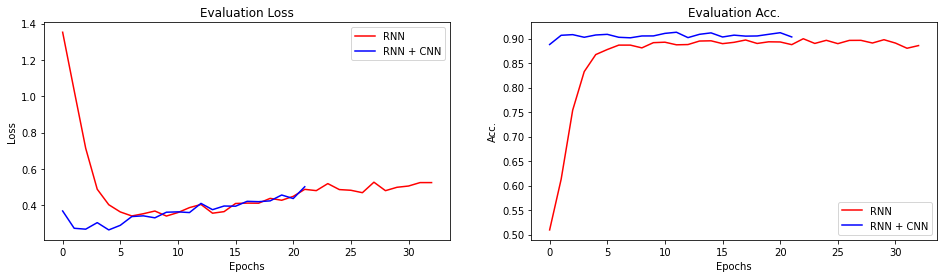

In [36]:
print(f"Test acc: RNN: {test_acc_rnn:.3f}, RNN + CNN: {test_acc_rnn_cnn:.3f}")

get_plot([hist_rnn, hist_rnn_cnn], ["RNN",'RNN + CNN'], len(hist_rnn['val_loss']))

## Q2. Time Series Regression


In this task, let's use RNN for time series regression. Please download the dataset from https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset

The dataset has the following columns:
- timestamp: index as datetime value
- cnt: new bike shares count
- t1: actual temp in Celcius
- t2: temp in Celcius which feels like
- hum: % of humidity
- wind_speed: speed of wind in km/hr
- weather_code: weather category
- is_holiday — holiday-1, non-holiday-2 
- is_weekend: weekend-1, weekday-0
- season: 0-spring, 1-summer, 2-fall, 3-winter


Column `cnt` is the target of our regression.

In [38]:
data = pd.read_csv("london_merged.csv", parse_dates = ['timestamp'], index_col ='timestamp')
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


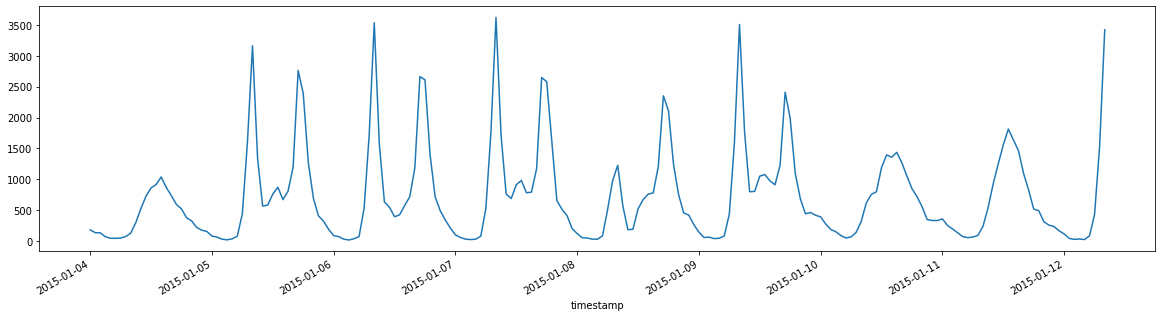

In [39]:
data.iloc[0:200]["cnt"].plot(figsize=(20,5))

You're required to build a model to predict the hourly `cnt`. This problem can be formulated as following:

- Given data $[X_{t-L+1},X_{t-L+2}, ..., X_{t}]$, predict $Y_{t+1}$. For example, if $L = 4$, we'll use data from the 1st to 4th hours to predict the bikes shared in the 5th hour, data from 2nd to 5th hours to predict the 6th hour, and so on.
- Every $X_{t}$ has a number of features. Let's use `cnt, t1, t2, hum, wind_speed` as features. In other words, we'll use past bike sharing quantities along with temperature and other variables to predict how many bikes will be shared in the next hour.
- To be more specific, the following code shows how your first two samples should look like:

In [40]:
L = 4
feature_cols = ["cnt","t1","t2","hum","wind_speed"]
target_col = 'cnt'

# first sample
X1 = data.iloc[0:4][feature_cols]
Y1 = data.iloc[4][target_col]
print(f"X1:\n {X1}\n Y1: {Y1}")

print("\n")
# 2nd sample
X2 = data.iloc[1:5][feature_cols]
Y2 = data.iloc[5][target_col]

print(f"X2:\n {X2}\n Y2: {Y2}")

X1:
                      cnt   t1   t2    hum  wind_speed
timestamp                                            
2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0
2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0
2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0
2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0
 Y1: 47.0


X2:
                      cnt   t1   t2    hum  wind_speed
timestamp                                            
2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0
2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0
2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0
2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5
 Y2: 46.0


### Q2.1. Preprocessing


Write a function `transform_data(data, feature_cols, target_col, cut_off_index, timestep=8)` to transform the dataset to a format that can be used by RNN. **Carefully follow the instruction below to define this function as follows**:
- Take the following arguments:
    - `data`: the dataframe created from the csv file
    - `feature_cols`: a list of features to be used for prediction
    - `target_col`: the target column name
    - `cut_off_index`: the index to split data into training and test subsets. Data after this point is reserved for testing only
    - `timestep`: the length of historical data that can be used for prediction. The default value is 8 (i.e. 8 hours)
- Split `data` by `cut_off_index`
- Normalize the dataset: Notice that the features are in different scales. We need to normalize the data first. 
    - You can use `MinMaxSaler`, `StandardScaler`, or `RobustScaler` to transform the dataset. Check https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing for details.
    - You can `only fit the scaler using the training dataset` (avoid data leaking). You need to fit a scaler for X (i.e., features) and another scaler for Y (i.e., target).
    - Transform the entire dataset (i.e., `data`) using the fitted scalers. If you want to transform the databack to the orginal, you can call the scalers' `inverse_transform` function. 
    - Slice the transformed dataset in every `timestep` rows, i.e.,  
        - Let ($X_i, Y_i$) denote the $i$th sample. $X_i$ `= S[i : (i + timestep), feature_cols]` and $Y_i$ `= S[ i + timestep, target_col]`, where `S` is the transformed array of `data`, 
         
    - The training subset should have records ($X_i, Y_i$) for $i=0$ to `cut_off_index - Timestep +1`. Use the rest as the test subset.
    - Return the transformed training X/Y, testing X/Y, and the fitted X and Y scalers.
    
Note, you may be wondering why not apply batch normalization. For time series data with trending, batch normalization may not work, since a random batch cannot preserve the trending of the time series. 

In [41]:
import numpy as np
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

def transform_data(data, feature_cols, target_col, cut_off_index, timestep=8):
    X = []  # input
    Y = []  # target
   
    train_data = data.iloc[0: cut_off_index]
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    x_scaler.fit(train_data[feature_cols].values)
    y_scaler.fit(train_data[target_col].values)
    
    X_normalized = x_scaler.transform(data[feature_cols].values)
    Y_normalized = y_scaler.transform(data[target_col].values)
    
    for idx in range(0, len(data)):
        
        if idx+timestep >= len(data):
            break
            
        x = X_normalized[idx:(idx+timestep)]
        y = Y_normalized[idx+timestep]
        
        X.append(x)
        Y.append(y)
        
    X = np.array(X)
    Y = np.array(Y).reshape(-1)
    
    train_X = X[0: cut_off_index - timestep + 1]
    train_Y = Y[0: cut_off_index - timestep + 1]
    
    test_X = X[(cut_off_index - timestep + 1):]
    test_Y = Y[(cut_off_index - timestep + 1):]
    
    
    return train_X, train_Y , test_X, test_Y, x_scaler, y_scaler

Let's set `cut_off_index = 15000` , `feature_cols = ["cnt","t1","t2","hum","wind_speed"]`, and `target_col = cnt`. Transform the dataset to get train/test X and Y.

In [42]:
cut_off_index = 15000
feature_cols = ["cnt","t1","t2","hum","wind_speed"]
target_col = ['cnt']
train_X, train_Y , test_X, test_Y, x_scaler, y_scaler = transform_data(data, feature_cols, target_col, cut_off_index, timestep=8)

In [43]:
# Show a few transformed examples

train_X[0]
train_Y[0]

test_X[0]
test_Y[0]

array([[-0.89142933, -1.74259585, -1.48069179,  1.52220096, -1.29900762],
       [-0.93161   , -1.74259585, -1.40644337,  1.52220096, -1.42509311],
       [-0.93526279, -1.8306977 , -1.40644337,  1.76577483, -2.05552053],
       [-0.99188101, -1.91879955, -1.48069179,  2.0093487 , -2.05552053],
       [-1.01471093, -1.91879955, -1.77768549,  1.52220096, -1.23596488],
       [-1.01562413, -1.91879955, -1.48069179,  1.52220096, -1.55117859],
       [-1.01105814, -2.09500324, -1.92618234,  2.0093487 , -1.17292213],
       [-0.98914141, -2.09500324, -1.92618234,  2.0093487 , -1.17292213]])

-0.9380023807279542

array([[-0.54350126,  1.16476518,  1.11800308, -0.91353771,  0.52923192],
       [-0.64577933,  1.07666333,  1.04375466, -0.63516757,  0.40314643],
       [-0.78184569,  1.07666333,  1.04375466, -0.49598251,  0.27706095],
       [-0.92065164,  1.07666333,  1.04375466, -0.21761237,  0.08793272],
       [-0.94896075,  1.07666333,  1.04375466, -0.04363104,  0.08793272],
       [-0.96813788,  0.63615409,  0.67251253,  0.82627563,  0.02488998],
       [-0.87407859,  0.54805224,  0.59826411,  1.00025696,  0.15097546],
       [-0.69509197,  0.63615409,  0.67251253,  0.82627563,  0.59227466]])

-0.27502133895339026

### Q2.2: Establish a naive baseline

Create a function `evaluate_naive_method` to estalish a baseline. This can help you check if your model is in the right track. 
- A simple baseline can be the `moving average`, i.e., the mean of `cnt` values in each input sequence as the baseline. For example, the moving average of `test_X[0]` showing above is -0.797
- Calculate the `mean absolute error (MAE)` on the `testing data` as the baseline. For example, the mae for `test_X[0]` is `| - 0.797 - (-0.275) | = 0.5222`
- Feel free to use more advanced method, i.e. ARIMA, to creat a baseline. 

In [44]:
def evaluate_naive_method(test_X, test_Y):
    mae = []
    preds = np.mean(test_X, axis = 1)
    error = np.abs(preds - test_Y)
    mae = error.mean(axis = 0)
    
    return mae

In [45]:
mae = evaluate_naive_method(test_X[:,:,0], test_Y)
print("mae: {0:.3f}".format(mae))

mae: 0.715


### Q2.3. Create train, evaluation, and test dataset

- As usual, create a dataset class
- Create dataset objects for training and test subsets
- Randomly sample 2400 instances from the training dataset as the evaluation dataset. 

In [46]:
class Bike_dataset(Dataset):
    def __init__(self, featuers, targets):
        self.length = len(featuers)
        self.features = torch.Tensor(featuers)
        self.targets = torch.Tensor(targets)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]
    
    def __len__(self):
        return self.length

In [47]:
train_dataset = Bike_dataset(train_X, train_Y)
test_dataset = Bike_dataset(test_X, test_Y)

sizes = [len(train_X) - 2400, 2400]
train_dataset, eval_dataset = random_split(train_dataset, sizes)
print(len(train_dataset), len(eval_dataset), len(test_dataset))

12593 2400 2413


### Q2.4. Define RNN model


Create a neural network model as follows:
    - The input to the model is the the training samples you created in Q2.1. 
    - Add LSTM or GRU layers into the model
    - Add other appropriate layers or mechanisms, e.g. Dropout, regularizers.
    - The output predicts the transformed `cnt` value of the next hour 
    - Carefully choose your hyperparameters, e.g. the number of hidden units in the LSTM/GRU layer, epochs, batch size etc.
   

In [48]:
class Bike_Model(nn.Module):
    
    def __init__(self, feature_dim, hidden_dim, lstm_layers = 1 ):
        
        super(Bike_Model, self).__init__()

        # Defining some parameters
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers

        # RNN Layer
        self.bilstm = nn.LSTM(input_size = self.feature_dim, hidden_size = self.hidden_dim, \
                            bidirectional = True,\
                            num_layers = self.num_layers, batch_first=True)
        
        self.lstm = nn.LSTM(input_size = self.hidden_dim*2, hidden_size = self.hidden_dim*2, \
                            bidirectional = False, batch_first=True)

        self.fc = nn.Linear(self.hidden_dim*2, 1)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        
        
        # Passing in the input and hidden state into the model and obtaining outputs
        out, _ = self.bilstm(x)
        
        out = self.dropout(out)
        
        out, _ = self.lstm(out)
        
        out = out[:, -1, :]
        
        out = self.dropout(out)
        
        out = self.fc(out)
        
        return out

### Q2.5. Define a train function

Modify the train function you used before to train this model:
- This is a regression problem. You should use MSE or MAE as the loss function
- During training, report train and test MAE in addition to loss
- Test the model after training completes. Generate prediction and report the MAE on the testing dataset. If your model is well tuned, `your test MAE should be less than 0.20`.
- Use the scaler to inverse transform the predictions to get actual forecast. Plot actual values and forecast.



In [49]:
def train_model(model, train_dataset, test_dataset, device, binary_pred = False,\
                lr=0.0005, epochs=20, batch_size=32):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # move model to device
    model = model.to(device)
    
    # early stopping
    patience = 10
    max_loss = np.inf
    cnt = 0

    # history
    history = {'train_loss': [],
               'train_mae': [],
               'test_loss': [],
               'test_mae': []}
    # setup loss function and optimizer
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    
    criterion = nn.MSELoss()
        #criterion = nn.L1Loss()

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_mae = 0
        test_loss = 0
        test_mae = 0

        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1)

            cur_train_loss = criterion(outputs, y)
            cur_train_mae = torch.abs(outputs - y).mean().item()
                
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += cur_train_loss
            train_mae += cur_train_mae

        # evaluation start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                
                # predict
                outputs = model(x).view(-1)
                cur_test_loss = criterion(outputs, y)
                cur_test_mae = torch.abs(outputs - y).mean().item()
                
                # loss and acc
                test_loss += cur_test_loss
                test_mae += cur_test_mae
                

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        val_loss = (test_loss/len(test_loader)).item()
        train_mae = (train_mae/len(train_loader))
        val_mae = (test_mae/len(test_loader))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['test_mae'].append(val_mae)
        
        print(f"Epoch:{epoch + 1} / {epochs}, \ttrain loss:{train_loss:.4f},\ttrain_mae:{train_mae:.4f}, \tvalid loss:{val_loss:.4f},\tvalid mae:{val_mae:.4f}")
        
        # early stopping
        if max_loss > test_loss:
            max_loss = test_loss 
            cnt = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("model saved!")
        else:
            cnt += 1
         
            if cnt == patience:
                print("early stopping!")
                break
        
        model.load_state_dict(torch.load("best_model.pth"))
        
    
    return model, history

In [50]:
def test_model(model, test_dataset, batch_size = 64):    # get test performance
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    test_mae = 0
    ys = []
    preds = []
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)
            y = y.to(device)
            # predict
            outputs = model(x).view(-1)    
            ys.append(y.cpu().numpy())
            preds.append(outputs.cpu().numpy())
    
    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    
    test_mae = np.abs(preds - ys).mean()
        
    print(f"Test mae: {test_mae:.4f}")
    
    
    return test_mae, preds

#### Train model

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Bike_Model(len(feature_cols), hidden_dim=12, lstm_layers = 1 )
print(model)
model, hista = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      device=device,
                      binary_pred = True,
                      lr=0.0005,
                      epochs=100,
                      batch_size=128)

Bike_Model(
  (bilstm): LSTM(5, 12, batch_first=True, bidirectional=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Training Start
Epoch:1 / 100, 	train loss:0.7436,	train_mae:0.6416, 	valid loss:0.5418,	valid mae:0.5067
model saved!
Epoch:2 / 100, 	train loss:0.4526,	train_mae:0.4699, 	valid loss:0.3178,	valid mae:0.3578
model saved!
Epoch:3 / 100, 	train loss:0.3165,	train_mae:0.4006, 	valid loss:0.2323,	valid mae:0.3034
model saved!
Epoch:4 / 100, 	train loss:0.2661,	train_mae:0.3635, 	valid loss:0.1863,	valid mae:0.2805
model saved!
Epoch:5 / 100, 	train loss:0.2375,	train_mae:0.3443, 	valid loss:0.1754,	valid mae:0.2715
model saved!
Epoch:6 / 100, 	train loss:0.2109,	train_mae:0.3231, 	valid loss:0.1527,	valid mae:0.2503
model saved!
Epoch:7 / 100, 	train loss:0.1939,	train_mae:0.3083, 	valid loss:0.1234,	valid mae:0.2307
model saved!
Epoch:8 / 100, 	train loss:0.1794,	train_mae:0

In [52]:
test_mae, preds = test_model(model, test_dataset, batch_size = 64)

Test mae: 0.1693


In [73]:
inverse_pred.reshape(1, -1)

array([[1220.5645 , 1978.8457 , 2123.9558 , ...,  547.4038 ,  348.3562 ,
         205.73943]], dtype=float32)

In [72]:
inverse_pred.ravel()

array([1220.5645 , 1978.8457 , 2123.9558 , ...,  547.4038 ,  348.3562 ,
        205.73943], dtype=float32)

In [68]:
inverse_pred = y_scaler.inverse_transform(preds.reshape(-1, 1))
actual_y = data.iloc[cut_off_index:len(data)-1]['cnt']
forecast = pd.DataFrame({'transformed_y':test_Y, 
                         "Predicted":preds, 
                         "Actual":actual_y, 
                         'forecast': inverse_pred.ravel()})
forecast.head()

,transformed_y,Predicted,Actual,forecast
timestamp,,,,
2016-09-25 08:00:00,-0.275021,0.056985,397,1220.564453
2016-09-25 09:00:00,0.221758,0.749445,857,1978.845703
2016-09-25 10:00:00,0.724929,0.881959,1401,2123.955811
2016-09-25 11:00:00,1.123997,0.818515,1952,2054.480957
2016-09-25 12:00:00,1.422612,0.867640,2389,2108.275879


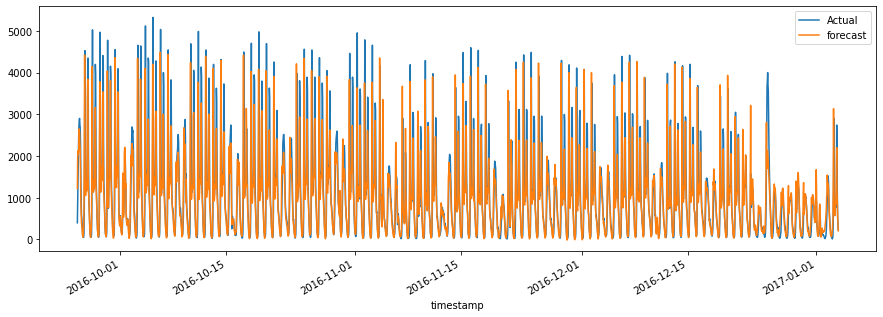

In [69]:
forecast[["Actual","forecast"]].plot(figsize=(15, 5))

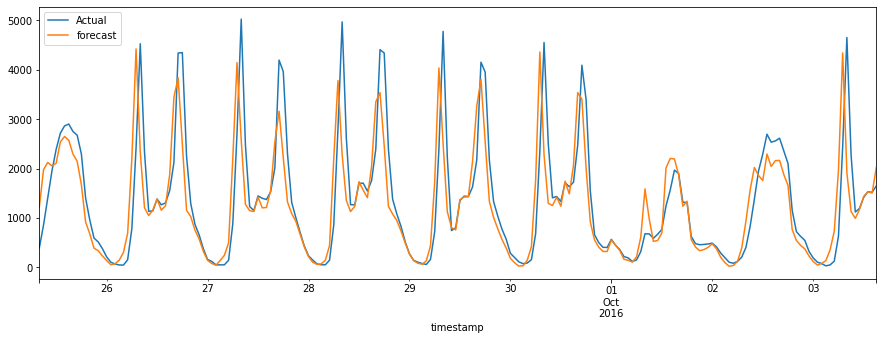

In [74]:
forecast[["Actual","forecast"]].iloc[0:200].plot(figsize=(15, 5))

### Q2.6.(Bonus): Predict biking sharing for the next 24 hours


Hope you have achieved your goal! So far we predict the bike sharing for the next hour. Can you modify your model to `predict the biking sharing for the next 24 hours`? You can enlarge the input sequence to include history data in the past a few days (e.g. 7 days). 

Hint: This is a sequence to sequence model. You should follow the neural translation model.

Good luck!